# Forward: The best way to learn.

`by struggling until you achieve mastery`

## In this Notebook we will:
- Get and untar data with `tf.keras.utils.get_file` utility function.
- List files with `tf.data.Dataset.list_files` (will be useful later)
- Load and Preprocess images with `tf.keras.preprocessing.image.ImageDataGenerator`
- Load Resnet V2 with TensorFlow Hub
- Train a `Sequential` model with the Keras API
- Interpret model predictions with TF2

__-Harrison__ 

# Lesson 1 - What's your pet

Welcome to lesson 1! For those of you who are using a Jupyter Notebook for the first time, you can learn about this useful tool in a tutorial we prepared specially for you; click `File`->`Open` now and click `00_notebook_tutorial.ipynb`. 

In this lesson we will build our first image classifier from scratch, and see if we can achieve world-class results. Let's dive in!

Every notebook starts with the following three lines; they ensure that any edits to libraries you make are reloaded here automatically, and also that any charts or images displayed are shown in this notebook.

We import all the necessary packages. We are going to work with the [fastai V1 library](http://www.fast.ai/2018/10/02/fastai-ai/) which sits on top of [Pytorch 1.0](https://hackernoon.com/pytorch-1-0-468332ba5163). The fastai library provides many useful functions that enable us to quickly and easily build neural networks and train our models.

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

<img src="images/fastailogo.png" width="100" align='left'>

In [ ]:
from fastai.vision import *
from fastai.metrics import error_rate
bs = 32
# bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

<img src="images/tflogo.png" width="80" align='left'>

In [3]:
import tensorflow as tf
import tensorflow_hub as hub
import pathlib
import tf_fastai.tf_fastai as tf_fai

print(tf.__version__)
bs=32

2.1.0


If you're using a computer with an unusually small GPU, you may get an out of memory error when running this notebook. If this happens, click Kernel->Restart, uncomment the 2nd line below to use a smaller *batch size* (you'll learn all about what this means during the course), and try again.

## Looking at the data

We are going to use the [Oxford-IIIT Pet Dataset](http://www.robots.ox.ac.uk/~vgg/data/pets/) by [O. M. Parkhi et al., 2012](http://www.robots.ox.ac.uk/~vgg/publications/2012/parkhi12a/parkhi12a.pdf) which features 12 cat breeds and 25 dogs breeds. Our model will need to learn to differentiate between these 37 distinct categories. According to their paper, the best accuracy they could get in 2012 was 59.21%, using a complex model that was specific to pet detection, with separate "Image", "Head", and "Body" models for the pet photos. Let's see how accurate we can be using deep learning!

We are going to use the `untar_data` function to which we must pass a URL as an argument and which will download and extract the data.

### FastAI
<img src="images/fastailogo.png" width="100" align='left'>

In [ ]:
help(untar_data)

In [ ]:
path = untar_data(URLs.PETS); path

In [ ]:
path.ls()

In [ ]:
path_anno = path/'annotations'
path_img = path/'images'

___

### TF2
<img src="images/tflogo.png" width="80" align='left'>

In [4]:
path_img = pathlib.Path('E://Data/Oxford-IIT-Pet')


The first thing we do when we approach a problem is to take a look at the data. We _always_ need to understand very well what the problem is and what the data looks like before we can figure out how to solve it. Taking a look at the data means understanding how the data directories are structured, what the labels are and what some sample images look like.

The main difference between the handling of image classification datasets is the way labels are stored. In this particular dataset, labels are stored in the filenames themselves. We will need to extract them to be able to classify the images into the correct categories. Fortunately, the fastai library has a handy function made exactly for this, `ImageDataBunch.from_name_re` gets the labels from the filenames using a [regular expression](https://docs.python.org/3.6/library/re.html).

___
### FAI
<img src="images/fastailogo.png" width="100" align='left'>

In [ ]:
fnames = get_image_files(path_img) #Return list of files in `c` that are images
fnames[:5]

In [ ]:
np.random.seed(2)
pat = r'/([^/]+)_\d+.jpg$'

data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(), size=224, bs=bs
                                  ).normalize(imagenet_stats)

data.show_batch(rows=3, figsize=(7,6))

In [ ]:
print(data.classes)
len(data.classes),data.c

___
### TF2
<img src="images/tflogo.png" width="80" align='left'>

Start with implementing the `ImageDataGenerator` API. Later on we will work with customizing the data input pipeline to maximize the GPU utilization.

__Later__
Create a function that returns (image, label) pairs to generate a TF2 dataset. Some changes with the regex pattern sins I am working on Windows. The FAI regex should still work on Unix Systems. 

- [Loading Images](https://www.tensorflow.org/tutorials/load_data/images)
- [Decoding and resizing images](https://www.tensorflow.org/guide/data#decoding_image_data_and_resizing_it) 
- `tf.data.Dataset` [docs](https://www.tensorflow.org/api_docs/python/tf/data/Dataset)

__-Harrison__ 

In [5]:
import re
import matplotlib.pyplot as plt
import numpy as np
import os

def reformat_files(file_dir):
    """TensorFlow is straight broke with a flat dir format gfor image classification
        Instead of fighting tf, I just reformatted the file structure very quickly
    """
    pat_windows = re.compile('([^\\\\]+)_\d+.jpg$')
    #pat_unix = r'([^/]+)_\d+.jpg$'
    file_names = os.listdir(file_dir)
    #gets names of subdirectories already in folder
    classes = [o for o in os.listdir(file_dir) 
                    if os.path.isdir(os.path.join(file_dir,o))]
    for f in file_names:
        if os.path.isdir(os.path.join(file_dir, f)):
            continue
        try:
            class_ = re.findall(pat_windows, f)[0]
        except:
            print(f)
            continue
        if class_ not in classes: #no subdirectory for class? Make one.
            classes.append(class_)
            os.mkdir(os.path.join(file_dir, class_))
        os.replace(os.path.join(file_dir, f), os.path.join(file_dir, class_, f))

def show_batch(train_data_gen):
    image_batch, label_batch = next(train_data_gen)
    plt.figure(figsize=(10,10))
    for n in range(9):
        ax = plt.subplot(3,3,n+1)
        plt.imshow(image_batch[n])
        plt.title(CLASSES[label_batch[n]==1][0].title())
        plt.axis('off')
    plt.show()

In [6]:
#reformat_files(path_img)
CLASSES = np.array(os.listdir(path_img))
print("Classes:", os.listdir(path_img))
print("Num_Classes:", len(os.listdir(path_img)))

Classes: ['Abyssinian', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'Bengal', 'Birman', 'Bombay', 'boxer', 'British_Shorthair', 'chihuahua', 'Egyptian_Mau', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'Maine_Coon', 'miniature_pinscher', 'newfoundland', 'Persian', 'pomeranian', 'pug', 'Ragdoll', 'Russian_Blue', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'Siamese', 'Sphynx', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']
Num_Classes: 37


In [7]:
fnames = tf.data.Dataset.list_files(str(path_img/'*'/'*'))
for f in fnames.take(5): #Creates a new dataset w/ at most n elements
    print(f.numpy())

b'E:\\Data\\Oxford-IIT-Pet\\Egyptian_Mau\\Egyptian_Mau_83.jpg'
b'E:\\Data\\Oxford-IIT-Pet\\newfoundland\\newfoundland_35.jpg'
b'E:\\Data\\Oxford-IIT-Pet\\great_pyrenees\\great_pyrenees_134.jpg'
b'E:\\Data\\Oxford-IIT-Pet\\miniature_pinscher\\miniature_pinscher_91.jpg'
b'E:\\Data\\Oxford-IIT-Pet\\Bombay\\Bombay_1.jpg'


In [8]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
                                    rescale=1./255, 
                                     horizontal_flip=True,
                                    rotation_range=5,
                                    width_shift_range=.05,
                                    height_shift_range=.05,
                                     zoom_range=0.2,
                                validation_split=0.2)

train_data = image_generator.flow_from_directory(batch_size = bs,
                                          directory = path_img,
                                          shuffle=True,
                                          target_size=(224,224),
                                                subset='training')

val_data = image_generator.flow_from_directory(batch_size = bs,
                                          directory = path_img,
                                          shuffle=True,
                                          target_size=(224,224),
                                              subset='validation')

Found 5913 images belonging to 37 classes.
Found 1477 images belonging to 37 classes.


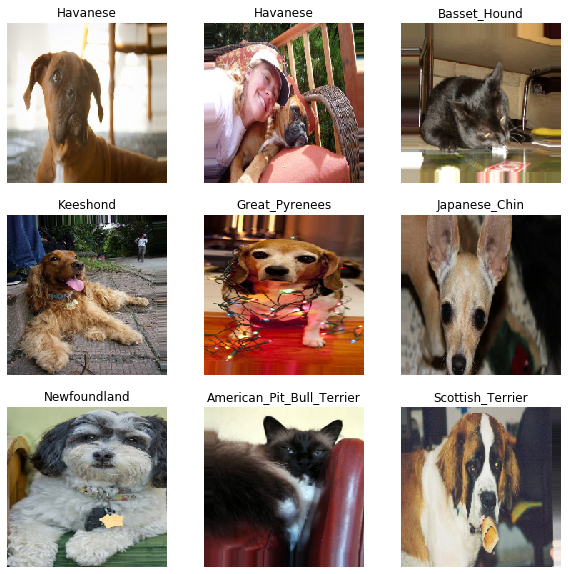

In [9]:
show_batch(train_data)

## Training: resnet34

Now we will start training our model. We will use a [convolutional neural network](http://cs231n.github.io/convolutional-networks/) backbone and a fully connected head with a single hidden layer as a classifier. Don't know what these things mean? Not to worry, we will dive deeper in the coming lessons. For the moment you need to know that we are building a model which will take images as input and will output the predicted probability for each of the categories (in this case, it will have 37 outputs).

We will train for 4 epochs (4 cycles through all our data).

___
### FAI
<img src="images/fastailogo.png" width="100" align='left'>

In [ ]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [ ]:
learn.model

In [ ]:
learn.fit_one_cycle(4)

In [ ]:
learn.save('stage-1')

___
### TF2
<img src="images/tflogo.png" width="80" align='left'>

One cool thing to use for transfer learning is __Tensorflow Hub__. There are tutorials online about how to load a mode architecture with only a URL.

__ResNet V2__ image classification architecture put forth in this [paper](https://arxiv.org/abs/1603.05027).(2016) In V2, batch normalization is used before every weight layer. TFHub uses `hub.load()` and `hub.KerasLayer` to load from a url.

Both essentially call `tf.saved_model.load()` [link](https://www.tensorflow.org/guide/saved_model) `KerasLayer` wraps the result for integration with other Keras layers, allowing use within `tf.keras.Sequential` [link](https://www.tensorflow.org/hub/migration_tf2#summary_of_the_new_api)

__-Harrison__ 

In [14]:
import tensorflow_hub as hub

feature_extractor_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4" #@param {type:"string"}

learn = tf.keras.Sequential([
  hub.KerasLayer(feature_extractor_url, 
                 input_shape=(224,224,3),
                trainable=False),
  tf.keras.layers.Dense(len(CLASSES), activation='softmax')
])
learn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 2048)              23564800  
_________________________________________________________________
dense_1 (Dense)              (None, 37)                75813     
Total params: 23,640,613
Trainable params: 75,813
Non-trainable params: 23,564,800
_________________________________________________________________


#### With Adaptive Learning Rates

In [15]:
learn.compile(optimizer=tf.keras.optimizers.Adam(),
             loss='categorical_crossentropy',
             metrics=['acc'])

In [16]:
learn.fit_generator(train_data, 
                    steps_per_epoch=train_data.samples//bs,
                    validation_data = val_data, 
                    validation_steps = val_data.samples // bs,
                    #callbacks=[cb], 
                    epochs=4)

  ...
    to  
  ['...']
  ...
    to  
  ['...']


Train for 184 steps, validate for 46 steps
Epoch 1/4
184/184 [==============================] - 132s 717ms/step - loss: 0.8600 - acc: 0.7551 - val_loss: 0.4670 - val_acc: 0.8526
Epoch 2/4
184/184 [==============================] - 132s 719ms/step - loss: 0.3213 - acc: 0.8964 - val_loss: 0.4167 - val_acc: 0.8573
Epoch 3/4
184/184 [==============================] - 124s 675ms/step - loss: 0.2306 - acc: 0.9216 - val_loss: 0.4064 - val_acc: 0.8621
Epoch 4/4
184/184 [==============================] - 131s 712ms/step - loss: 0.1888 - acc: 0.9386 - val_loss: 0.4253 - val_acc: 0.8682


## Results

Let's see what results we have got. 

We will first see which were the categories that the model most confused with one another. We will try to see if what the model predicted was reasonable or not. In this case the mistakes look reasonable (none of the mistakes seems obviously naive). This is an indicator that our classifier is working correctly. 

Furthermore, when we plot the confusion matrix, we can see that the distribution is heavily skewed: the model makes the same mistakes over and over again but it rarely confuses other categories. This suggests that it just finds it difficult to distinguish some specific categories between each other; this is normal behaviour.

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

In [ ]:
interp.plot_top_losses(9, figsize=(15,11))

In [ ]:
doc(interp.plot_top_losses)

In [ ]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [ ]:
interp.most_confused(min_val=2)

## Unfreezing, fine-tuning, and learning rates

Since our model is working as we expect it to, we will *unfreeze* our model and train some more.

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(1)

In [ ]:
learn.load('stage-1');

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

That's a pretty accurate model!

## Training: resnet50

Now we will train in the same way as before but with one caveat: instead of using resnet34 as our backbone we will use resnet50 (resnet34 is a 34 layer residual network while resnet50 has 50 layers. It will be explained later in the course and you can learn the details in the [resnet paper](https://arxiv.org/pdf/1512.03385.pdf)).

Basically, resnet50 usually performs better because it is a deeper network with more parameters. Let's see if we can achieve a higher performance here. To help it along, let's us use larger images too, since that way the network can see more detail. We reduce the batch size a bit since otherwise this larger network will require more GPU memory.

In [ ]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(),
                                   size=299, bs=bs//2).normalize(imagenet_stats)

In [ ]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(8)

In [ ]:
learn.save('stage-1-50')

It's astonishing that it's possible to recognize pet breeds so accurately! Let's see if full fine-tuning helps:

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(1e-6,1e-4))

If it doesn't, you can always go back to your previous model.

In [ ]:
learn.load('stage-1-50');

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

In [ ]:
interp.most_confused(min_val=2)

## Other data formats

In [ ]:
path = untar_data(URLs.MNIST_SAMPLE); path

In [ ]:
tfms = get_transforms(do_flip=False)
data = ImageDataBunch.from_folder(path, ds_tfms=tfms, size=26)

In [ ]:
data.show_batch(rows=3, figsize=(5,5))

In [ ]:
learn = cnn_learner(data, models.resnet18, metrics=accuracy)
learn.fit(2)

In [ ]:
df = pd.read_csv(path/'labels.csv')
df.head()

In [ ]:
data = ImageDataBunch.from_csv(path, ds_tfms=tfms, size=28)

In [ ]:
data.show_batch(rows=3, figsize=(5,5))
data.classes

In [ ]:
data = ImageDataBunch.from_df(path, df, ds_tfms=tfms, size=24)
data.classes

In [ ]:
fn_paths = [path/name for name in df['name']]; fn_paths[:2]

In [ ]:
pat = r"/(\d)/\d+\.png$"
data = ImageDataBunch.from_name_re(path, fn_paths, pat=pat, ds_tfms=tfms, size=24)
data.classes

In [ ]:
data = ImageDataBunch.from_name_func(path, fn_paths, ds_tfms=tfms, size=24,
        label_func = lambda x: '3' if '/3/' in str(x) else '7')
data.classes

In [ ]:
labels = [('3' if '/3/' in str(x) else '7') for x in fn_paths]
labels[:5]

In [ ]:
data = ImageDataBunch.from_lists(path, fn_paths, labels=labels, ds_tfms=tfms, size=24)
data.classes

## Brief Aside: PathLib Object

In [ ]:
import pathlib
p = pathlib.PosixPath() #Path subclass for non-Windows systems.

p.exists() #Whether this path exists.
p.glob() #Iterate over this subtree and yield all existing files matching regex
p.absolute() #Return an absolute version of this path. 
p.is_file()#Whether this path is a regular file
p.ls()
p.mkdir() #Create a new directory at this given path.
p.rename() #Rename this path to the given path.
p.rmdir() #Remove this directory.  The directory must be empty.
p.touch() #Create this file with the given access mode, if it doesn't exist.